In [ ]:
MODEL_NAME = "facebook/m2m100_418M"
DATASET_NAME = "opus_books"
DATASET_CONFIG = "de-en"
TRAIN_SIZE = 5000
VAL_SIZE = 500
TEST_SIZE = 500
MAX_LENGTH = 128
BATCH_SIZE = 4
EPOCHS = 5
FP16 = True
BACKTRANSLATE_N = 2000
SEED = 42
OUTPUT_DIR = "models/mt_en_de_pipeline"


In [ ]:
# run in notebook cell
!pip install -q transformers datasets sentencepiece sacrebleu evaluate accelerate matplotlib uvicorn fastapi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os, random, math, time
os.environ["WANDB_DISABLED"] = "true"   # disable wandb prompts
REPORT_TO = ["none"]

import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    M2M100ForConditionalGeneration,
    M2M100Tokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
import evaluate

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
print("Loading dataset:", DATASET_NAME, DATASET_CONFIG)
ds_all = load_dataset(DATASET_NAME, DATASET_CONFIG)

print("Available splits:", list(ds_all.keys()))
# if no test split, fallback: validation -> test; if no validation, create split
if "test" not in ds_all:
    if "validation" in ds_all:
        ds_all["test"] = ds_all["validation"]
        print("Using 'validation' as 'test' split.")
    else:
        ds_all = ds_all["train"].train_test_split(test_size=0.1, seed=SEED)
        print("Created train/test split from 'train'.")

# show sample structure
print("\nSample entry keys and example:")
sample = ds_all[list(ds_all.keys())[0]][0]
print("Top-level keys:", list(sample.keys()))
print("Sample:", sample)


Loading dataset: opus_books de-en


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00001.parquet:   0%|          | 0.00/8.80M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51467 [00:00<?, ? examples/s]

Available splits: ['train']
Created train/test split from 'train'.

Sample entry keys and example:
Top-level keys: ['id', 'translation']
Sample: {'id': '28872', 'translation': {'de': 'Solche neu erworbene Staaten sind entweder schon früher an die Herrschaft gewöhnt gewesen, oder die Freiheit ist in ihnen hergebracht. Sie werden erworben: durch fremde Gewalt, oder durch eigne Kräfte; durch Glück, oder durch Tapferkeit.', 'en': 'Such dominions thus acquired are either accustomed to live under a prince, or to live in freedom; and are acquired either by the arms of the prince himself, or of others, or else by fortune or by ability.'}}


In [ ]:
print("Loading dataset:", DATASET_NAME, DATASET_CONFIG)
ds_all = load_dataset(DATASET_NAME, DATASET_CONFIG)

print("Available splits:", list(ds_all.keys()))
# if no test split, fallback: validation -> test; if no validation, create split
if "test" not in ds_all:
    if "validation" in ds_all:
        ds_all["test"] = ds_all["validation"]
        print("Using 'validation' as 'test' split.")
    else:
        ds_all = ds_all["train"].train_test_split(test_size=0.1, seed=SEED)
        print("Created train/test split from 'train'.")

# show sample structure
print("\nSample entry keys and example:")
sample = ds_all[list(ds_all.keys())[0]][0]
print("Top-level keys:", list(sample.keys()))
print("Sample:", sample)


Loading dataset: opus_books de-en
Available splits: ['train']
Created train/test split from 'train'.

Sample entry keys and example:
Top-level keys: ['id', 'translation']
Sample: {'id': '28872', 'translation': {'de': 'Solche neu erworbene Staaten sind entweder schon früher an die Herrschaft gewöhnt gewesen, oder die Freiheit ist in ihnen hergebracht. Sie werden erworben: durch fremde Gewalt, oder durch eigne Kräfte; durch Glück, oder durch Tapferkeit.', 'en': 'Such dominions thus acquired are either accustomed to live under a prince, or to live in freedom; and are acquired either by the arms of the prince himself, or of others, or else by fortune or by ability.'}}


In [ ]:
# create manageable splits (take min of requested size and available)
train_n = min(TRAIN_SIZE, len(ds_all["train"]))
val_n   = min(VAL_SIZE, len(ds_all.get("validation", ds_all["train"])))
test_n  = min(TEST_SIZE, len(ds_all["test"]))

print(f"Using train={train_n}, val={val_n}, test={test_n}")

train_data = ds_all["train"].select(range(train_n))
# prefer explicit validation split if available
if "validation" in ds_all:
    val_data = ds_all["validation"].select(range(val_n))
else:
    tmp = ds_all["train"].select(range(train_n, train_n + val_n))
    val_data = tmp

test_data = ds_all["test"].select(range(test_n))

# ensure entries have 'translation' mapping with 'en' & 'de'
def filter_has_en_de(x):
    t = x.get("translation", None)
    if not t:
        return False
    return ("en" in t and "de" in t and len(t["en"].strip())>0 and len(t["de"].strip())>0)

train_data = train_data.filter(filter_has_en_de)
val_data = val_data.filter(filter_has_en_de)
test_data = test_data.filter(filter_has_en_de)

print("Filtered sizes:", len(train_data), len(val_data), len(test_data))
print("Example pair (train[0]):", train_data[0]["translation"])


Using train=5000, val=500, test=500


Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filtered sizes: 5000 500 500
Example pair (train[0]): {'de': 'Solche neu erworbene Staaten sind entweder schon früher an die Herrschaft gewöhnt gewesen, oder die Freiheit ist in ihnen hergebracht. Sie werden erworben: durch fremde Gewalt, oder durch eigne Kräfte; durch Glück, oder durch Tapferkeit.', 'en': 'Such dominions thus acquired are either accustomed to live under a prince, or to live in freedom; and are acquired either by the arms of the prince himself, or of others, or else by fortune or by ability.'}


In [ ]:
print("Loading model:", MODEL_NAME)
tokenizer = M2M100Tokenizer.from_pretrained(MODEL_NAME)
model = M2M100ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

# For m2m100 set language codes before encoding/generation
tokenizer.src_lang = "en"
tokenizer.tgt_lang = "de"
print("Tokenizer/model loaded.")

Loading model: facebook/m2m100_418M


tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

Tokenizer/model loaded.


In [ ]:
def preprocess_batch(batch):
    # batch["translation"] is list of dicts {'en':..., 'de':...}
    srcs = [t["en"].strip() for t in batch["translation"]]
    tgts = [t["de"].strip() for t in batch["translation"]]
    enc = tokenizer(srcs, truncation=True, padding="max_length", max_length=MAX_LENGTH)
    with tokenizer.as_target_tokenizer():
        lbl = tokenizer(tgts, truncation=True, padding="max_length", max_length=MAX_LENGTH)
    # replace pad id with -100
    labels = [[(x if x != tokenizer.pad_token_id else -100) for x in seq] for seq in lbl["input_ids"]]
    enc["labels"] = labels
    return enc

print("Tokenizing train...")
tokenized_train = train_data.map(preprocess_batch, batched=True, remove_columns=train_data.column_names)
print("Tokenizing val...")
tokenized_val = val_data.map(preprocess_batch, batched=True, remove_columns=val_data.column_names)
print("Tokenizing test...")
tokenized_test = test_data.map(preprocess_batch, batched=True, remove_columns=test_data.column_names)

# convert to torch format for Trainer
tokenized_train.set_format(type="torch")
tokenized_val.set_format(type="torch")
tokenized_test.set_format(type="torch")

print("Tokenization done. Example keys:", tokenized_train.column_names)


Tokenizing train...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Tokenizing val...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing test...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenization done. Example keys: ['input_ids', 'attention_mask', 'labels']


In [ ]:
sacrebleu = evaluate.load("sacrebleu")
chrf = evaluate.load("chrf")

def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    labels = [[l.strip()] for l in labels]
    return preds, labels

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    # preds might be raw token ids (np array) or tuple
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    bleu = sacrebleu.compute(predictions=decoded_preds, references=decoded_labels)
    chrf_score = chrf.compute(predictions=decoded_preds, references=decoded_labels)
    return {"sacrebleu": bleu["score"], "chrF": chrf_score["score"]}


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    fp16=(FP16 and torch.cuda.is_available()),
    num_train_epochs=EPOCHS,
    logging_steps=100,
    save_total_limit=2,
    learning_rate=3e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="sacrebleu",
    greater_is_better=True,
    report_to=REPORT_TO,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)
print("Trainer ready.")

Trainer ready.


/tmp/ipython-input-1528132456.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
print("Starting training. This will print progress and metrics.")
start_time = time.time()
train_result = trainer.train()
elapsed = time.time() - start_time
print(f"Training finished in {elapsed/60:.2f} minutes.")

# Save artifacts
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Saved fine-tuned model to", OUTPUT_DIR)

print("Train metrics:", train_result.metrics)
eval_metrics = trainer.evaluate(tokenized_test)
print("Eval metrics on test:", eval_metrics)


Starting training. This will print progress and metrics.


/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss,Sacrebleu,Chrf
1,2.632800,2.395918,13.237220,39.775208
2,2.082600,2.306998,14.574690,41.082749
3,1.668700,2.289721,15.326679,42.024456
4,1.419400,2.274263,14.888549,41.854519
5,1.220900,2.292545,15.161893,42.002046


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Training finished in 57.95 minutes.
Saved fine-tuned model to models/mt_en_de_pipeline
Train metrics: {'train_runtime': 3475.7596, 'train_samples_per_second': 7.193, 'train_steps_per_second': 1.798, 'total_flos': 6772201881600000.0, 'train_loss': 1.8167785614013672, 'epoch': 5.0}


Eval metrics on test: {'eval_loss': 2.3665683269500732, 'eval_sacrebleu': 14.039557254195932, 'eval_chrF': 40.716177321980204, 'eval_runtime': 220.4725, 'eval_samples_per_second': 2.268, 'eval_steps_per_second': 0.567, 'epoch': 5.0}


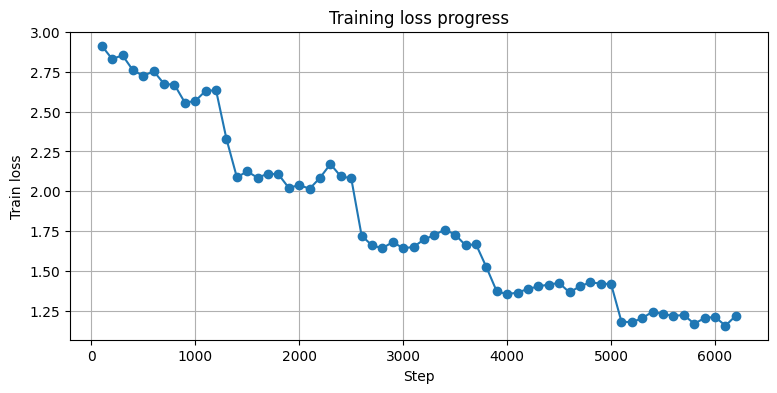

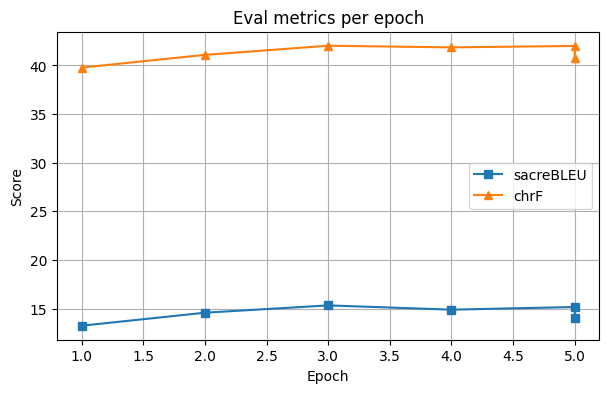

In [ ]:
logs = trainer.state.log_history
# training loss points
steps = [e["step"] for e in logs if "loss" in e]
losses = [e["loss"] for e in logs if "loss" in e]

plt.figure(figsize=(9,4))
if steps:
    plt.plot(steps, losses, marker="o")
    plt.xlabel("Step")
    plt.ylabel("Train loss")
    plt.title("Training loss progress")
    plt.grid(True)
    plt.show()
else:
    print("No loss entries in logs.")

# evaluation metrics per epoch
epochs = [e["epoch"] for e in logs if "eval_sacrebleu" in e]
bleus  = [e["eval_sacrebleu"] for e in logs if "eval_sacrebleu" in e]
chrfs  = [e["eval_chrF"] for e in logs if "eval_chrF" in e]
if bleus:
    plt.figure(figsize=(7,4))
    plt.plot(epochs, bleus, label="sacreBLEU", marker="s")
    plt.plot(epochs, chrfs, label="chrF", marker="^")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Eval metrics per epoch")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No evaluation metrics found in log history.")


In [ ]:
# helper
def translate(sentences, src_lang="en", tgt_lang="de", num_beams=5, max_length=MAX_LENGTH):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    # chunk to avoid OOM
    outputs = []
    batch_size = 16
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
        forced_bos = tokenizer.get_lang_id(tgt_lang)
        gen = model.generate(**enc, forced_bos_token_id=forced_bos, num_beams=num_beams, max_length=max_length)
        dec = tokenizer.batch_decode(gen, skip_special_tokens=True)
        outputs.extend(dec)
    return outputs

# test
en_samples = [
    "This is a test sentence about air quality.",
    "Machine translation models improve with more high-quality data."
]
print("EN -> DE:")
print(translate(en_samples, "en", "de"))

de_samples = [
    "Dies ist ein Testsatz zur Luftqualität.",
    "Neuronale Netze lernen mit größeren Datensätzen besser."
]
print("DE -> EN:")
print(translate(de_samples, "de", "en"))


EN -> DE:
['Dies ist eine Prüfungsprechung über Luftqualität.', 'Mechanische Übersetzungsmodelle verbessern sich mit hochwertigeren Daten.']
DE -> EN:
['This is a test set for air quality.', 'Neuronal networks learn better with larger databases.']


In [ ]:
print("Running compact back-translation augmentation with", BACKTRANSLATE_N, "samples.")
# take target-language monolingual sentences from training (German)
mono_de_list = [t["translation"]["de"] for t in train_data.select(range(min(BACKTRANSLATE_N, len(train_data))))]

# Translate DE -> EN using current (fine-tuned) model
synth_en = translate(mono_de_list, src_lang="de", tgt_lang="en", num_beams=4)

# Create synthetic parallel set: (synth_en, mono_de_list)
aug_ds = Dataset.from_dict({"translation": [{"en": e, "de": d} for e,d in zip(synth_en, mono_de_list)]})
print("Augmented dataset length:", len(aug_ds))

# tokenize augmentation
aug_tokenized = aug_ds.map(preprocess_batch, batched=True, remove_columns=["translation"])
aug_tokenized.set_format(type="torch")

# concatenate to the original tokenized_train
tokenized_train = concatenate_datasets([tokenized_train, aug_tokenized])
print("New training size after augmentation:", len(tokenized_train))

# update trainer's train_dataset and optionally re-train for 1 epoch more
trainer.train_dataset = tokenized_train
print("Re-running quick fine-tune for 1 more epoch on augmented data...")
trainer.args.num_train_epochs = 5
trainer.train()
trainer.save_model(OUTPUT_DIR)
print("Augmentation retrain finished. Model saved.")


Running compact back-translation augmentation with 2000 samples.
Augmented dataset length: 2000


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


New training size after augmentation: 7000
Re-running quick fine-tune for 1 more epoch on augmented data...


Epoch,Training Loss,Validation Loss,Sacrebleu,Chrf
1,1.531600,2.361308,13.810721,39.998977
2,1.154300,2.386161,13.766443,40.798457
3,0.865100,2.428676,14.441126,41.586756
4,0.671200,2.465696,14.866921,41.711452
5,0.517700,2.492458,15.086103,41.829027


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Augmentation retrain finished. Model saved.


In [ ]:
final_metrics = trainer.evaluate(tokenized_test)
print("Final test metrics:", final_metrics)

# show some test -> predicted pairs
sample_idx = list(range(10))
test_srcs = [x["translation"]["en"] for x in test_data.select(sample_idx)]
preds = translate(test_srcs, src_lang="en", tgt_lang="de")
for s,p in zip(test_srcs, preds):
    print("SRC:", s)
    print("PRED:", p)
    print("-"*60)


Final test metrics: {'eval_loss': 2.58211088180542, 'eval_sacrebleu': 14.373210074684096, 'eval_chrF': 41.02951910309866, 'eval_runtime': 224.1887, 'eval_samples_per_second': 2.23, 'eval_steps_per_second': 0.558, 'epoch': 5.0}
SRC: I turned, and Miss Ingram darted forwards from her sofa: the others, too, looked up from their several occupations; for at the same time a crunching of wheels and a splashing tramp of horse-hoofs became audible on the wet gravel.
PRED: Ich wandte mich um, und Miß Ingram zog sich von ihrem Sofa vorwärts; die übrigen sahen sich auch aus ihren verschiedenen Beschäftigungen hervor, denn zu gleicher Zeit hörte man in dem nassen Kragen ein Stück Räder und ein schiefer Rauschenhütchen auf dem nassen Pferde.
------------------------------------------------------------
SRC: I found that I could never let anyone else deal with this sort of work unless I wanted to harm both the client and the job I had taken on.
PRED: Ich fand, daß ich niemals jemand anderes mit dieser

In [ ]:
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("Saved to", OUTPUT_DIR)


Saved to models/mt_en_de_pipeline


In [ ]:
!rm -f /content/mt_model.zip
